## Exploratory Data Analysis (EDA) for Seasonal Investing

The objective of this analysis is to study and backtest seasonal investing strategies based on the variables present in the `summary_table`. Seasonal investing involves identifying patterns in asset returns that occur at specific times of the year, allowing investors to capitalize on these trends.

In this analysis, we will:
1. Examine the monthly returns of the selected asset over the specified time period.
2. Analyze the average returns for each month to identify any seasonal trends.
3. Utilize the `summary_table` to summarize key metrics and insights derived from the monthly returns.
4. Backtest potential seasonal investing strategies based on the identified trends.

This EDA will provide a foundation for understanding the seasonal behavior of the asset and guide investment decisions.

### Explanation of why this could lead to better investing compared to normal DCA

The calculated metrics provide a deeper understanding of the asset's performance over time. 
By analyzing average returns, standard deviation, and the percentage of positive returns, 
investors can identify months with historically strong performance and adjust their investment 
strategies accordingly. 

The skewness and kurtosis metrics help assess the risk and return profile of the asset, 
allowing investors to make more informed decisions. 

The Kelly ratio and fraction provide insights into optimal investing sizing, which can enhance 
returns while managing risk. 

In contrast to normal Dollar-Cost Averaging (DCA), which invests a fixed amount regularly 
regardless of market conditions, this approach allows for a more strategic allocation of 
capital based on historical performance patterns. This can potentially lead to higher returns 
and reduced risk by capitalizing on seasonal trends rather than a static investment strategy.




# **Disclaimer:** 
The information provided in this analysis is for educational purposes only and should not be considered financial advice. Any financial decisions made based on this analysis are the sole responsibility of the reader and not the author. While this exploratory data analysis (EDA) may discuss potential strategies for utilizing the data, these strategies may evolve based on personal experiences or in conjunction with other software I develop, which may not be presented here. For instance, if the data indicates positive returns in a specific month, I may analyze that month further and use additional tools to optimize my timing. Additionally, external factors such as news events may influence my personal investment decisions and may not be reflected in this analysis.


In [41]:
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy


In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import os
from datetime import datetime, timedelta

class MonthlySeasonalityAnalyzer:
    def __init__(self, ticker='SPY'):
        self.ticker = ticker
        self.start = (datetime.now() - timedelta(days=365 * 10)).strftime('%Y-%m-%d')  # 10 years ago
        self.end = datetime.now().strftime('%Y-%m-%d')  # Current date
        self.data = None
        self.pivot_table = None
        self.summary_table = None

    def fetch_and_process_data(self):
        # Fetch data
        self.data = yf.download(self.ticker, start=self.start, end=self.end, progress=False)['Adj Close']
        
        # Calculate monthly returns
        monthly_data = self.data.resample('M').ffill()
        monthly_returns = monthly_data.pct_change().dropna() * 100  # Convert to percentage
        
        # Organize returns into a pivot table
        monthly_returns = monthly_returns.to_frame(name='Adj Close')
        monthly_returns['Year'] = monthly_returns.index.to_period('M').year
        monthly_returns['Month'] = monthly_returns.index.to_period('M').month
        monthly_returns['Month'] = monthly_returns['Month'].apply(lambda x: pd.Timestamp(datetime.now().year, x, 1).strftime('%b'))  # Using strftime to get month abbreviation
        self.pivot_table = monthly_returns.pivot_table(index='Year', columns='Month', values='Adj Close', aggfunc='mean')
        self.pivot_table = self.pivot_table.fillna(0)  # Replace NaN with 0 for months without data

    def calculate_metrics(self):
        # Ensure columns are in the correct order
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        self.pivot_table = self.pivot_table[months]

        # Function to calculate Kelly ratio and fraction
        def calculate_kelly_ratio(returns):
            win_prob = np.mean(returns > 0)
            loss_prob = 1 - win_prob
            win_return = np.mean(returns[returns > 0])
            loss_return = abs(np.mean(returns[returns < 0]))
            kelly_ratio = win_prob - (loss_prob / (win_return / loss_return))
            return kelly_ratio, kelly_ratio / 2  # Kelly fraction as half of Kelly ratio

        # Calculate metrics
        avg_returns = self.pivot_table.mean()
        std_dev = self.pivot_table.std()
        pos_perc = (self.pivot_table > 0).mean() * 100
        skewness = self.pivot_table.apply(lambda x: skew(x.dropna()), axis=0)
        kurt = self.pivot_table.apply(lambda x: kurtosis(x.dropna()), axis=0)

        # Calculate up days and down days
        up_days = (self.pivot_table > 0).sum()
        down_days = (self.pivot_table < 0).sum()

        # Kelly ratio and fraction
        kelly_ratios = self.pivot_table.apply(lambda x: calculate_kelly_ratio(x.dropna()), axis=0)
        avg_kelly_ratio = kelly_ratios.apply(lambda x: x[0])
        avg_kelly_fraction = kelly_ratios.apply(lambda x: x[1])

        # Create summary table
        self.summary_table = pd.DataFrame({
            'Avg Returns (%)': avg_returns,
            'StDev (%)': std_dev,
            'Pos %': pos_perc,
            'Skewness': skewness,
            'Kurtosis': kurt,
            'Avg Kelly Ratio': avg_kelly_ratio,
            'Avg Kelly Fraction': avg_kelly_fraction,
            'Up Days': up_days,
            'Down Days': down_days
        })

    def visualize_data(self):
        # Heatmap of monthly returns
        plt.figure(figsize=(14, 10))
        sns.heatmap(self.pivot_table, annot=True, fmt=".2f", cmap="RdYlGn", center=0, linewidths=.5, cbar_kws={"shrink": .75})
        plt.title(f'Monthly Returns Heatmap for {self.ticker}')
        plt.show()

        # Visualize summary table
        fig, ax = plt.subplots(figsize=(14, 4))  # Adjust the size as needed
        ax.axis('tight')
        ax.axis('off')
        ax.table(cellText=self.summary_table.values, colLabels=self.summary_table.columns, rowLabels=self.summary_table.index, cellLoc='center', loc='center')
        plt.title(f'Summary Table for {self.ticker}')
        plt.show()

    def save_to_directory(self):
        # Create directory if it doesn't exist
        directory = 'seasonality_data'
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        # Save pivot table and summary table to CSV files
        pivot_table_file = os.path.join(directory, f'{self.ticker}_pivot_table.csv')
        summary_table_file = os.path.join(directory, f'{self.ticker}_summary_table.csv')
        self.pivot_table.to_csv(pivot_table_file)
        self.summary_table.to_csv(summary_table_file)
        print(f'Data saved to {directory}.')


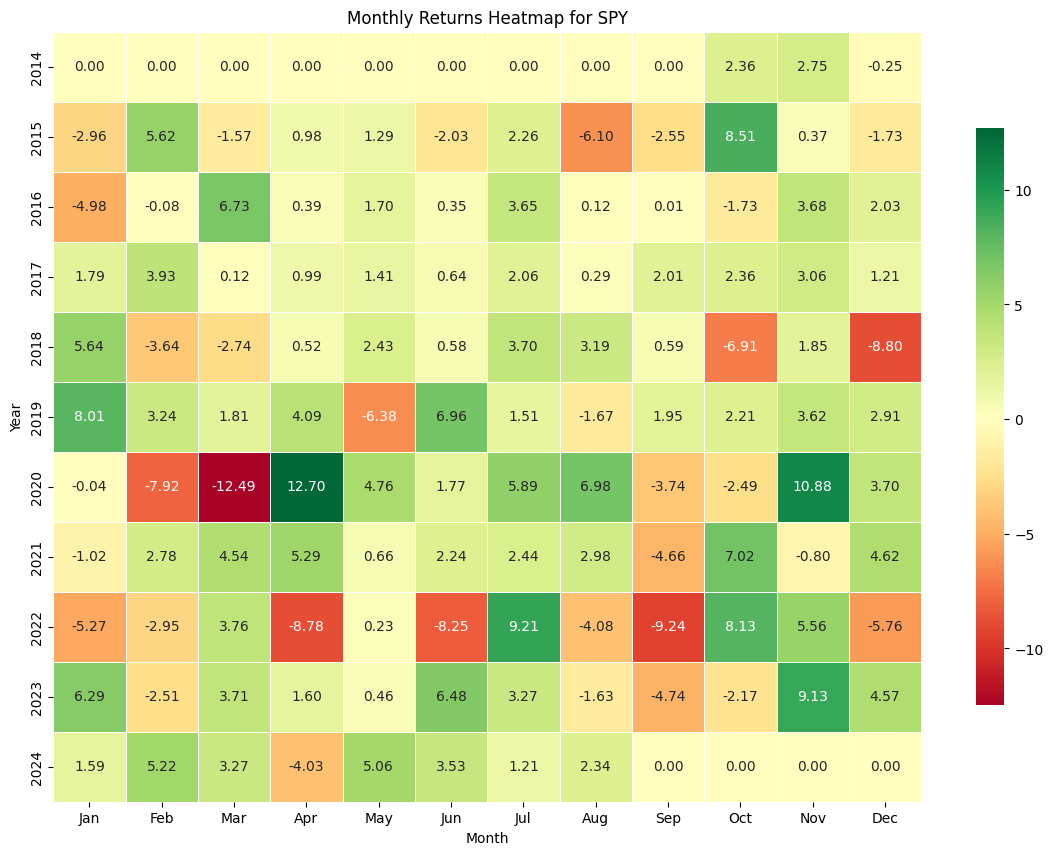

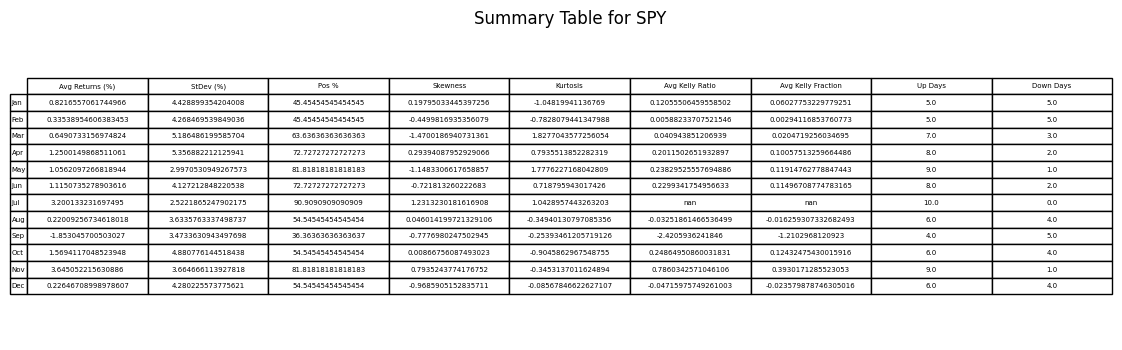

Data saved to seasonality_data.


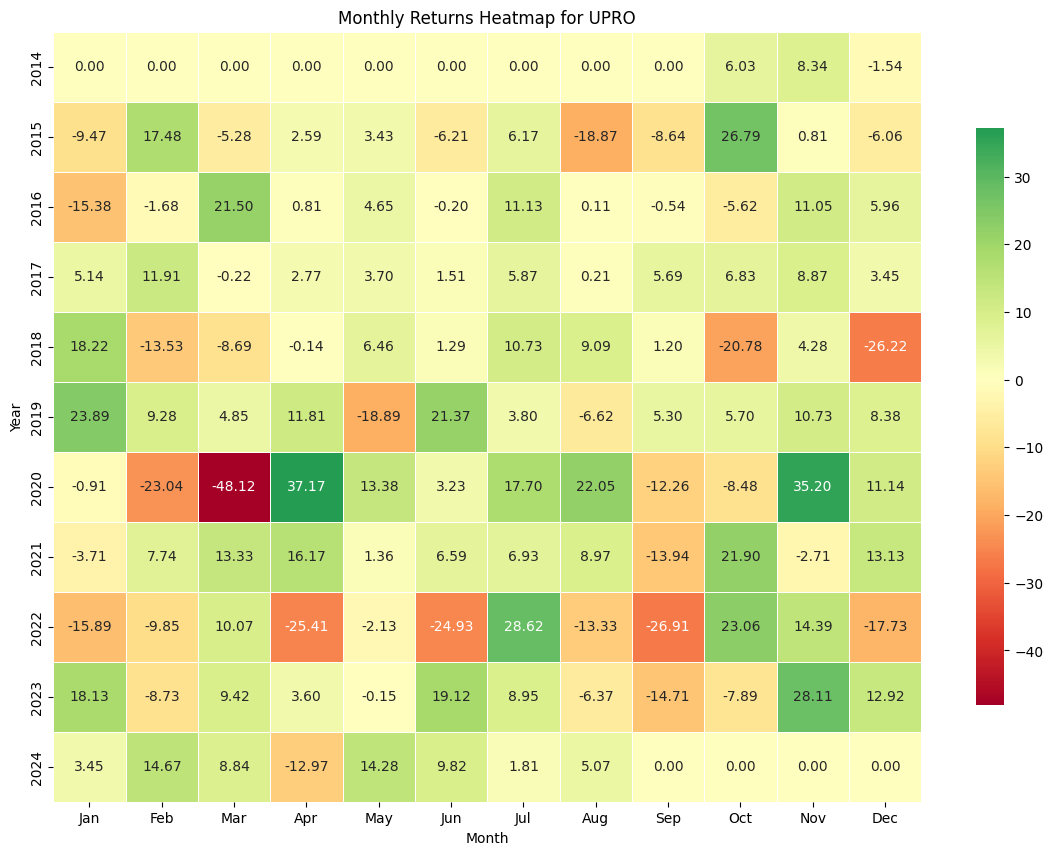

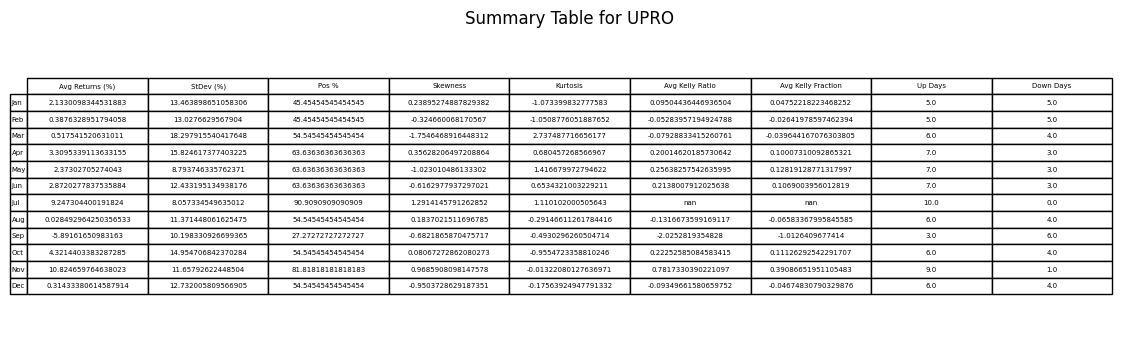

Data saved to seasonality_data.


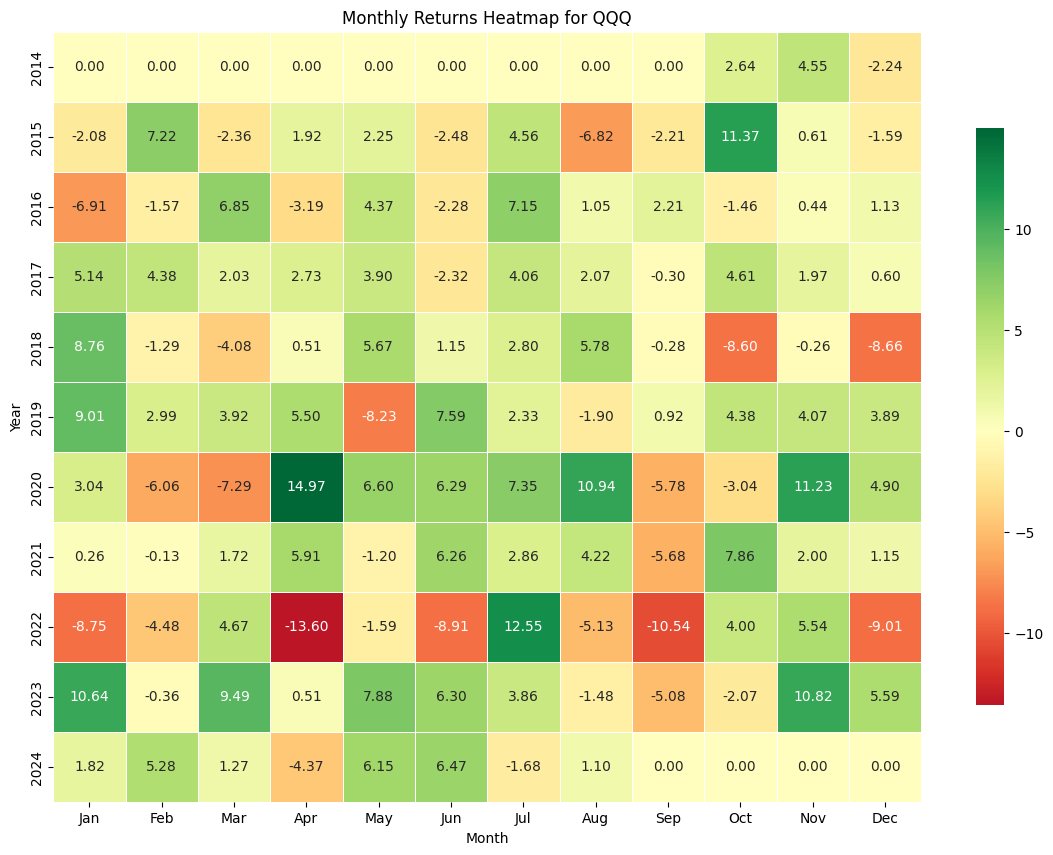

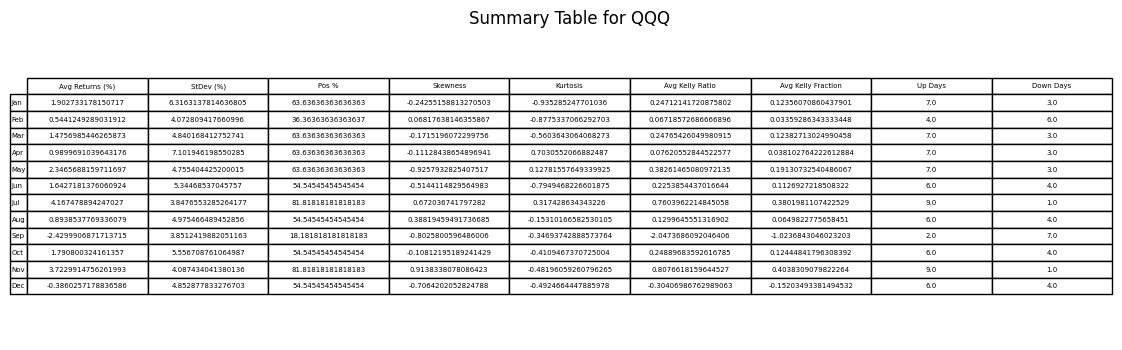

Data saved to seasonality_data.


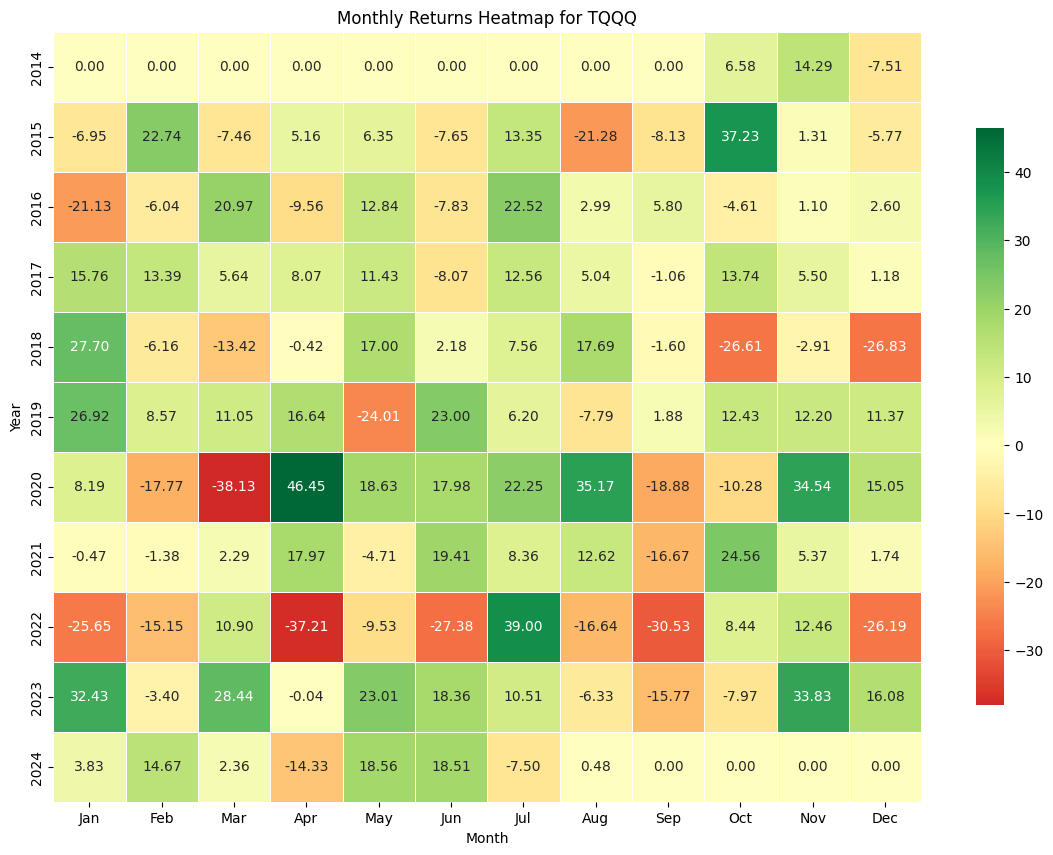

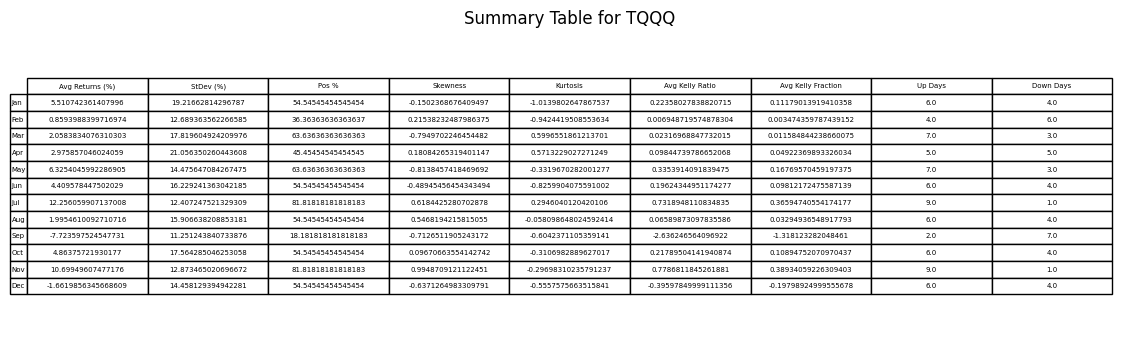

Data saved to seasonality_data.


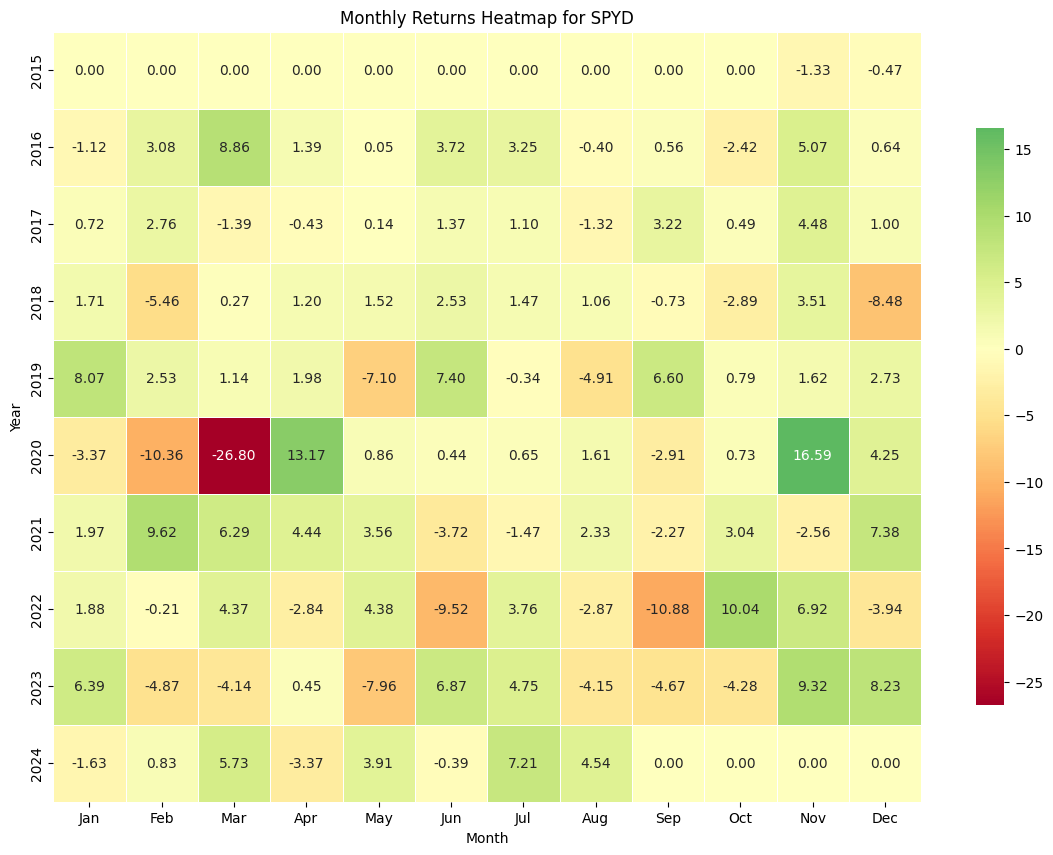

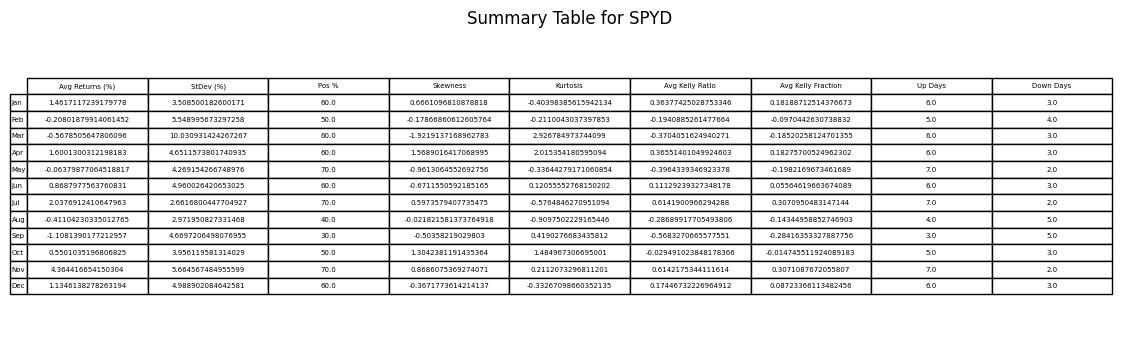

Data saved to seasonality_data.


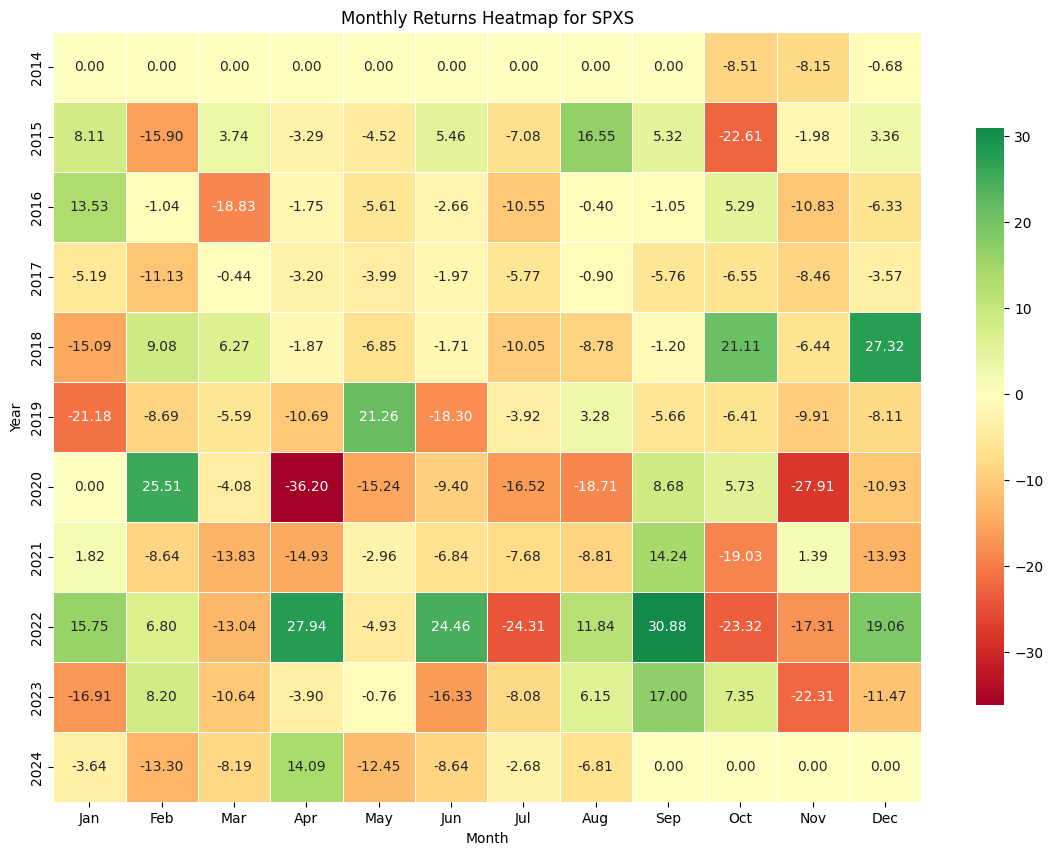

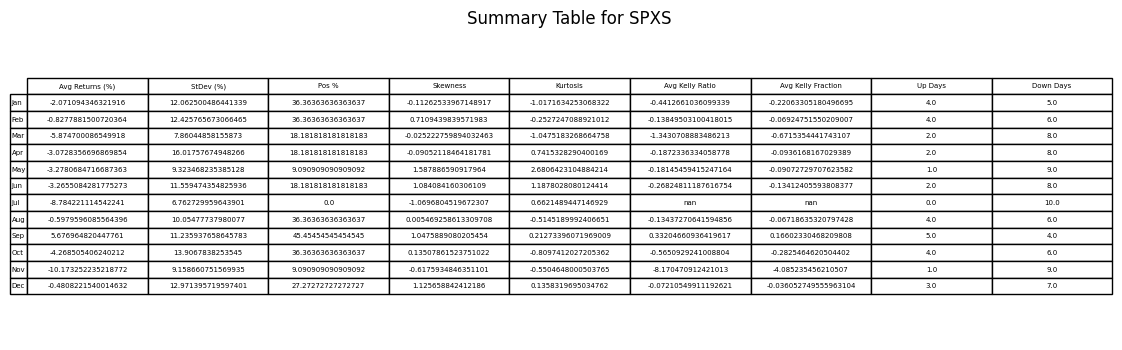

Data saved to seasonality_data.


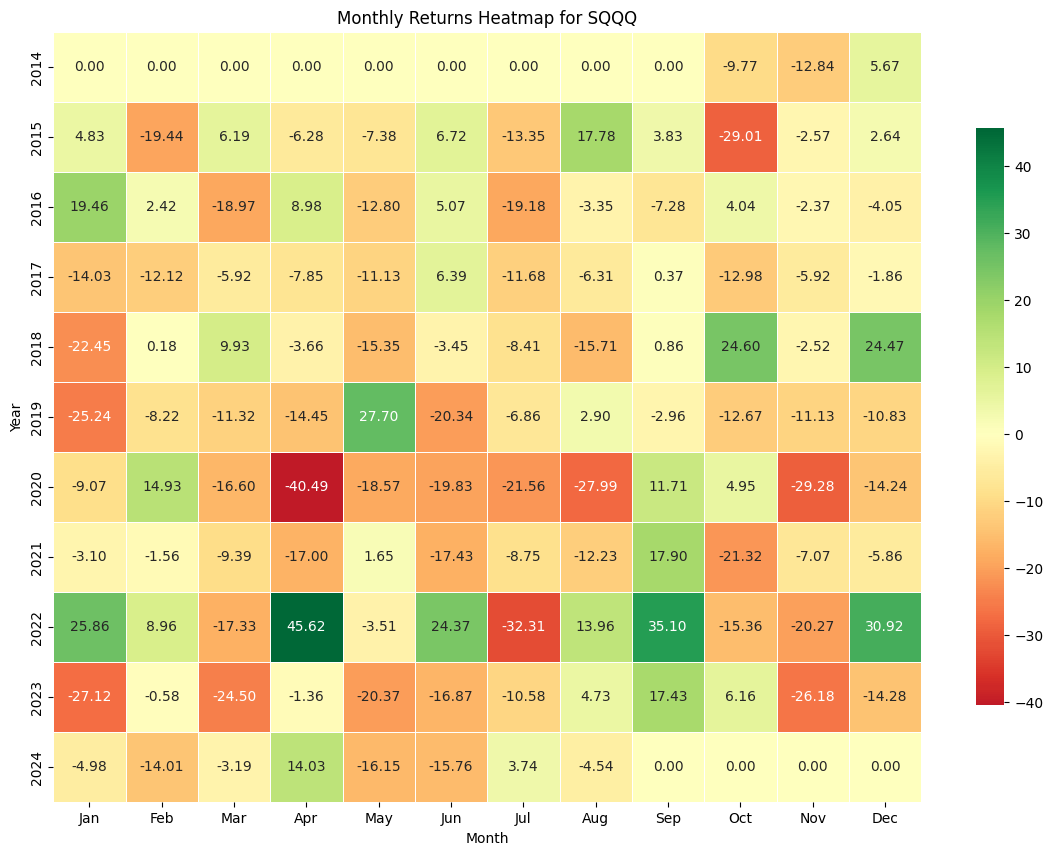

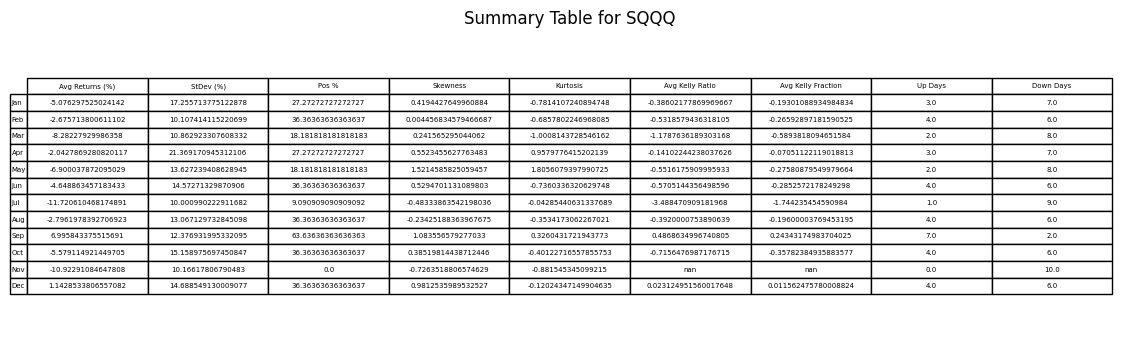

Data saved to seasonality_data.


In [43]:
tickers = ['SPY', 'UPRO','QQQ', 'TQQQ', 'SPYD', 'SPXS', 'SQQQ']
for ticker in tickers:
    analyzer = MonthlySeasonalityAnalyzer(ticker=ticker)
    analyzer.fetch_and_process_data()
    analyzer.calculate_metrics()
    analyzer.visualize_data()
    analyzer.save_to_directory()

In [44]:
income_tickers = ['SPYD','AGNC', 'QYLD', 'O', 'JEPI']
for ticker in income_tickers:
    analyzer = MonthlySeasonalityAnalyzer(ticker=ticker)
    analyzer.fetch_and_process_data()
    analyzer.calculate_metrics()
    # analyzer.visualize_data()
    analyzer.save_to_directory()

Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.


In [45]:
tech_tickers = ['SOXL', 'MSFT','NVDA','INTC', 'TSLA', 'AMD', 'SNAP', 'ENVX', 'GOOGL', 'CVNA', 'NFLX']
for ticker in tech_tickers:
    analyzer = MonthlySeasonalityAnalyzer(ticker=ticker)
    analyzer.fetch_and_process_data()
    analyzer.calculate_metrics()
    # analyzer.visualize_data()
    analyzer.save_to_directory()

Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.


In [46]:
crypto_tickers = ['BTC-USD', 'ETH-USD','RIOT', 'MARA', 'COIN', 'BITO']
for ticker in crypto_tickers:
    analyzer = MonthlySeasonalityAnalyzer(ticker=ticker)
    analyzer.fetch_and_process_data()
    analyzer.calculate_metrics()
    # analyzer.visualize_data()
    analyzer.save_to_directory()

Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
Data saved to seasonality_data.
